### Grokking example
We're just going to reproduce the experiments shown in the repo mentioned in "info.md"

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import os
# set working directory to the script's directory
os.chdir(os.path.dirname(os.path.abspath("main.py")))

In [4]:
from training import ExperimentParams
experiment_name = "arithmetic_experiment1"

df_loss = pd.read_csv(f"./results/{experiment_name}/loss_data.csv")
params = pd.read_csv(f"./results/{experiment_name}/params.csv").to_dict(orient='list')
params = {k: v[0] for k, v in params.items()}  # Convert to a dictionary with single values
params = ExperimentParams(**params)

Text(0.5, 1.0, 'Train & test correct answer % for modular addition with p=53')

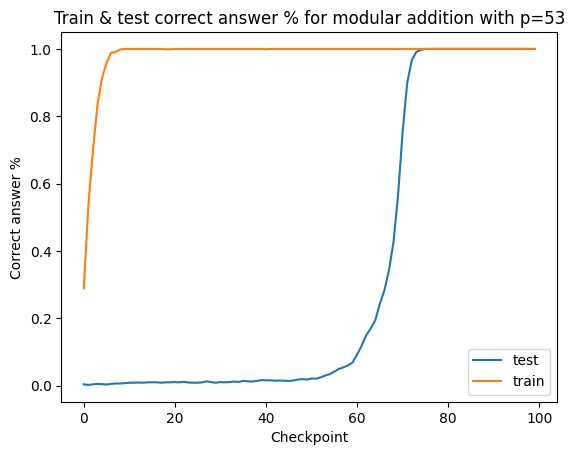

In [ ]:
plt.plot(df_loss["val_acc"], label="test")
plt.plot(df_loss["train_acc"], label="train")
plt.legend()
plt.ylabel("Correct answer %")
plt.xlabel("Checkpoint")
plt.title(f"Train & test correct answer % for modular addition with p={params.p}")

Text(0.5, 1.0, 'Train & test loss for modular addition with p=53')

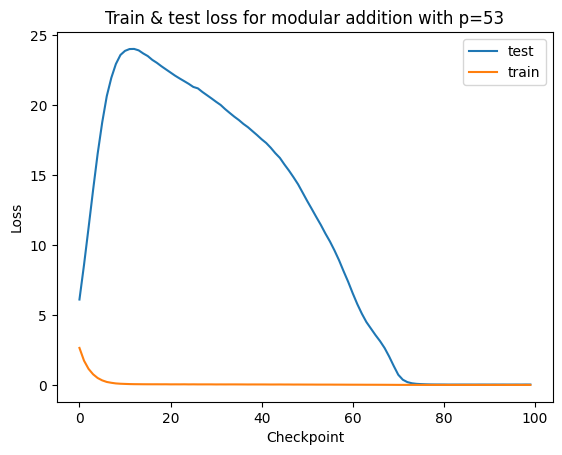

In [ ]:
plt.plot(df_loss["val_loss"], label="test")
plt.plot(df_loss["train_loss"], label="train")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Checkpoint")
plt.title(f"Train & test loss for modular addition with p={params.p}")

### LLC Analysis
Hey there! Here comes the LLC stuff

In [50]:
from devinterp.optim.sgld import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import evaluate_ce
import torch
from torch.utils.data import DataLoader
from arithmetic_models import MLP

train_data = torch.load(f"./results/{experiment_name}/datasets/train_data.pt")

model = MLP(params)
model.load_state_dict(torch.load(f"./results/{experiment_name}/checkpoints/model_25000.pt"))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
model.eval()
learning_coeff_stats = estimate_learning_coeff_with_summary(
    model=model,
    loader=DataLoader(train_data, batch_size=params.batch_size, shuffle=True),
    evaluate=evaluate_ce,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=0.093, nbeta=2.0, localization=5.0),
    num_chains=2,
    num_draws=500,
    device=DEVICE,
    online=True,
)
trace = learning_coeff_stats["loss/trace"]

/tmp/ipykernel_134262/4217698271.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(f"./results/{experiment_name}/datasets/train_data.pt")
/tmp/ipyk

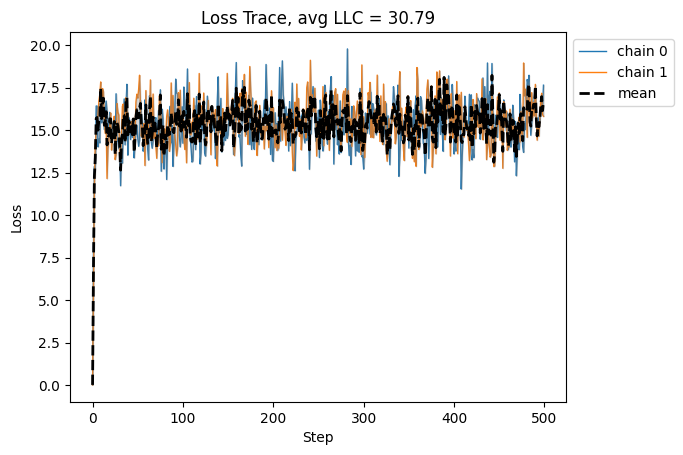

<Figure size 1200x900 with 0 Axes>

In [51]:
from devinterp.utils import plot_trace

plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

In [ ]:
lr = 3e-3
gamma = 5
nbeta = 2.0
num_draws = 500
num_chains = 2
llcs = []
n_checkpoints = params.n_save_model_checkpoints
check_points_every = params.epochs // params.print_times
model = MLP(params)

for i in range(n_checkpoints):
    try:
        model.load_state_dict(torch.load(f"./results/{experiment_name}/checkpoints/model_{(i+1) * check_points_every}.pt"))
    except FileNotFoundError:
        continue
    llcs.append(estimate_learning_coeff_with_summary(
        model=model,
        loader=DataLoader(train_data, batch_size=params.batch_size, shuffle=True),
        evaluate=evaluate_ce,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=0.003, nbeta=2.0, localization=5.0),
        num_chains=1,
        num_draws=500,
        device=DEVICE,
        online=False,
    )['llc/mean'])

df_loss["llc"] = llcs
df_loss.to_csv(f"./results/{experiment_name}/loss_data.csv", index=False)


/tmp/ipykernel_134262/3482241161.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"./results/{experiment_name}/checkpoints/model_{(i+1)

[21.242019653320312, 27.215497970581055, 33.77003860473633, 38.64531707763672, 39.30744934082031, 43.90327835083008, 45.04070281982422, 47.28429412841797, 46.550941467285156, 49.49495315551758, 49.78630065917969, 48.51676559448242, 46.643890380859375, 50.02583694458008, 46.473182678222656, 46.270751953125, 47.20658874511719, 45.314857482910156, 44.63695526123047, 45.39730453491211, 46.622886657714844, 44.12962341308594, 43.9387321472168, 44.73474884033203, 43.08845520019531, 43.440040588378906, 43.53553009033203, 44.6234130859375, 42.174739837646484, 43.00080108642578, 43.13983154296875, 42.27360153198242, 41.940704345703125, 42.20956802368164, 42.38044738769531, 39.85502624511719, 41.33723068237305, 41.419925689697266, 42.26814270019531, 41.169307708740234, 39.29229736328125, 41.07379913330078, 39.92053985595703, 39.84193420410156, 39.79560470581055, 39.11188507080078, 37.984188079833984, 39.249359130859375, 38.06734085083008, 37.083248138427734, 39.28155517578125, 37.31293487548828, 

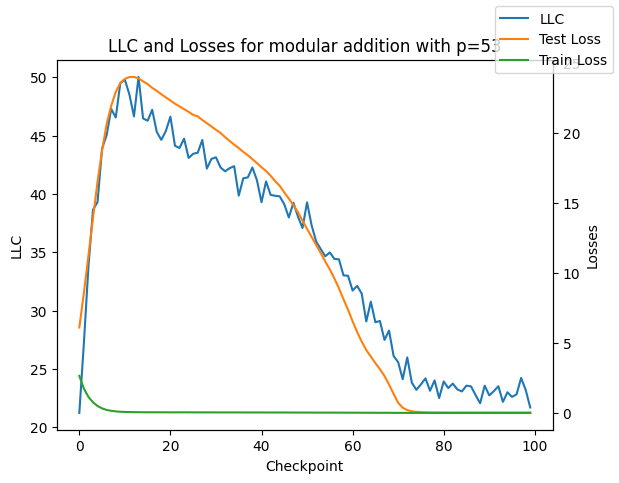

In [74]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df_loss["llc"], color='tab:blue', label="LLC")
ax2.plot(df_loss["val_loss"], color='tab:orange', label="Test Loss")
ax2.plot(df_loss["train_loss"], color='tab:green', label="Train Loss")

ax1.set_ylabel("LLC")
ax2.set_ylabel("Losses")
ax1.set_xlabel("Checkpoint")

plt.title(f"LLC and Losses for modular addition with p={params.p}")
fig.legend()
plt.show()